In [102]:
import json, os
import glob, pickle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, modify_and_add_noise_to_model
from gnn import ExpValCircuitGraphModel, ExpValCircuitGraphModel_2, ExpValCircuitGraphModel_3
from mlp import MLP1, MLP2, MLP3, encode_data
from collections import defaultdict
from sklearn.linear_model import LinearRegression

plt.style.use({'figure.facecolor':'white'})

In [103]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [104]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [105]:
model_path_1 = './model/ising/gnn3_ising.pth'
model_path_2 = './model/ising/mlp3_ising.pth'
model_path_3 = './model/ising/ols_full_ising.pk'
model_path_4 = './model/ising/ols_ising.pk'

In [106]:
models = []

model_1 = ExpValCircuitGraphModel_3(
    num_node_features=22,
    hidden_channels=25
)
model_1.load_state_dict(torch.load(model_path_1), strict=True)
model_1.eval()
models.append((model_1, 'gnn'))

model_2 = MLP3(
    input_size=58,
    output_size=4,
    hidden_size=128
)
model_2.load_state_dict(torch.load(model_path_2), strict=True)
model_2.eval()
models.append((model_2, 'mlp'))

with open(model_path_3, 'rb') as f:
    model_3 = pickle.load(f)
models.append((model_3, 'ols_full'))

with open(model_path_4, 'rb') as f:
    model_4 = pickle.load(f)
models.append((model_4, 'ols'))

In [107]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [108]:
test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/ising_dataset/val', '.pk')
print(len(test_circuits))

  0%|          | 0/5 [00:00<?, ?it/s]

2000


In [109]:
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]

In [110]:
df = []

for i, (circ, ideal_exp_val, noisy_exp_val) in tqdm(enumerate(zip(test_circuits, test_ideal_exp_vals, test_noisy_exp_vals))):
    row = dict()
    row['ideal'] = ideal_exp_val
    row['noisy'] = noisy_exp_val

    circ_trans = transpile(circ, backend, optimization_level=3)
    graph_data = circuit_to_graph_data_json(
                circuit=circ_trans,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
    entry = ExpValueEntry(
        circuit_graph=graph_data,
        observable=[],
        ideal_exp_value=ideal_exp_val,
        noisy_exp_values=[noisy_exp_val],
        circuit_depth=circ_trans.depth()
    ).to_pyg_data()

    X, _ = encode_data([circ_trans], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

    for j, (model, m_type) in enumerate(models):
        if m_type == 'mlp':
            row[f'model_{j}'] = model(X).tolist()[0]
        elif m_type == 'gnn':
            row[f'model_{j}'] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif m_type == 'ols_full':
            row[f'model_{j}'] = model.predict(X).tolist()[0]
        elif m_type == 'ols':
            row[f'model_{j}'] = model.predict(X[:, -4:]).tolist()[0]
        else:
            raise NotImplementedError

    df.append(row)

df = pd.DataFrame(df)

0it [00:00, ?it/s]

In [111]:
df

,ideal,noisy,model_0,model_1,model_2,model_3
0,"[0.1694, 0.0796, 0.0812, 0.1756]","[0.018, -0.026, 0.0662, 0.14]","[0.13543470203876495, 0.11075374484062195, 0.1...","[0.1394990086555481, 0.08520112931728363, 0.08...","[0.15771484375, 0.079559326171875, 0.081512451...","[0.17924273014068604, 0.1124551072716713, 0.11..."
1,"[0.1166, 0.143, 0.1354, 0.1182]","[-0.0074, 0.0136, 0.1014, 0.0918]","[0.1307079792022705, 0.10756529122591019, 0.10...","[0.09376347064971924, 0.09136368334293365, 0.0...","[0.108154296875, 0.113250732421875, 0.11517333...","[0.1256609857082367, 0.14090999960899353, 0.14..."
2,"[0.1264, 0.1176, 0.1262, 0.1254]","[-0.008, 0.0254, 0.1054, 0.1032]","[0.13537020981311798, 0.11104825139045715, 0.1...","[0.09376347064971924, 0.09136368334293365, 0.0...","[0.117462158203125, 0.12322998046875, 0.125167...","[0.13625195622444153, 0.1524987816810608, 0.15..."
3,"[0.0146, 0.065, 0.0658, 0.0246]","[-0.0688, -0.0386, 0.0278, -0.003]","[0.07267936319112778, 0.06591206789016724, 0.0...","[0.06955122947692871, 0.07410839945077896, 0.0...","[0.00958251953125, 0.032073974609375, 0.033073...","[0.02166048064827919, 0.050751157104969025, 0...."
4,"[0.203, 0.0422, 0.0392, 0.1994]","[0.0674, -0.027, 0.0478, 0.1886]","[0.14909043908119202, 0.12104973942041397, 0.1...","[0.16755610704421997, 0.08142061531543732, 0.0...","[0.20672607421875, 0.060211181640625, 0.061408...","[0.22691091895103455, 0.0900990441441536, 0.09..."
...,...,...,...,...,...,...
1995,"[0.9796, 0.9734, 0.9728, 0.9834]","[0.6024, 0.644, 0.8142, 0.8818]","[0.9426551461219788, 0.8953040242195129, 0.895...","[0.9130816459655762, 0.8758511543273926, 0.877...","[0.9735107421875, 0.96258544921875, 0.96376800...","[0.9639947414398193, 0.950322151184082, 0.9513..."
1996,"[0.1268, 0.1316, 0.1138, 0.1118]","[0.042, 0.0778, 0.0998, 0.0828]","[0.12096874415874481, 0.1025676354765892, 0.10...","[0.08404728770256042, 0.0861499160528183, 0.08...","[0.099273681640625, 0.11114501953125, 0.111412...","[0.09897401183843613, 0.11138060688972473, 0.1..."
1997,"[-0.0116, -0.0044, -0.0176, 0.0004]","[-0.0932, -0.0556, -0.0266, -0.031]","[0.021826408803462982, 0.030928069725632668, 0...","[0.017885617911815643, 0.01755698025226593, 0....","[-0.02392578125, -0.017913818359375, -0.016960...","[-0.015001965686678886, -0.004019379615783691,..."
1998,"[0.001, -0.0096, -0.0194, -0.0106]","[-0.0852, -0.0884, -0.0192, -0.016]","[0.023501122370362282, 0.032198041677474976, 0...","[0.010361626744270325, 0.004746474325656891, 0...","[-0.00152587890625, -0.014251708984375, -0.013...","[0.010006709024310112, 0.0027176542207598686, ..."


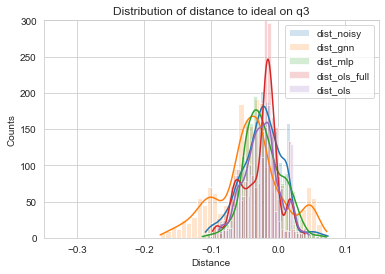

In [125]:
plt.figure()
plt.style.use({'figure.facecolor':'white'})
q = 3
dist_noisy = df['noisy'].apply(lambda x: x[q]) - df['ideal'].apply(lambda x: x[q])
sns.histplot(dist_noisy, kde=True, alpha=0.2, label='dist_noisy')
for i in range(len(models)):
    dist_model = df['noisy'].apply(lambda x: x[q]) - df[f'model_{i}'].apply(lambda x: x[q])
    sns.histplot(dist_model, kde=True, alpha=0.2, label=f'dist_{models[i][1]}')

plt.xlabel("Distance")
plt.ylabel("Counts")
plt.title(f"Distribution of distance to ideal on q{q}")
plt.xlim([-0.35, 0.15])
plt.ylim([0, 300])
plt.legend()
plt.show()
# Plot the distribution
# sns.histplot(dist_noisy, kde=True)
# plt.xlabel("Differences (Column2 - Column1)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Differences between First Entries of Column2 and Column1")
# plt.show()

In [31]:
from qiskit import *
from typing import TypedDict

import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value, Counts
from typing import Union, List, Dict

class CountsProcess:

    @classmethod
    def pauli_exp_val_all1Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                # In the string representation qubit-0 corresponds to the right-most Pauli character
                pauli = SparsePauliOp.from_sparse_list([("Z", [n], 1)], nq)
                expect = sampled_expectation_value(counts, pauli)
                if nolabels:
                    expects += [expect]
                else:
                    expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all1Q_for_counts(count)
                expects += [expect]
            return expects

    @classmethod
    def pauli_exp_val_all2Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns:
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                for m in range(n+1, nq):
                    # In the string representation qubit-0 corresponds to the right-most Pauli character
                    pauli = SparsePauliOp.from_sparse_list([("ZZ", [n,m], 1)], nq)
                    expect = sampled_expectation_value(counts, pauli)
                    if nolabels:
                        expects += [expect]
                    else:
                        expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all2Q_for_counts(count)
                expects += [expect]
            return expects


class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, sweep_steps = None, measure_bases = None):
        sweep_steps = sweep_steps or [16]
        measure_bases = measure_bases or ['Z']

        circs = []
        run_params = []
        for basis in measure_bases:
            for depth in range(*sweep_steps):
                ops['measure_basis'] = basis
                ops['depth'] = depth
                qc = cls.make_quantum_circuit(ops)
                qc.metadata = {}
                qc.metadata['measure_basis'] = basis
                qc.metadata['depth'] = depth
                run_params += [qc.metadata.copy()]
                circs += [qc]
        return circs, run_params

In [82]:
cls = IsingModel
ops = cls.Options()
ops.config_4q_paper()
# ops.config_10q_paper()
qc_list, run_params = cls.make_circs_sweep(ops, sweep_steps=[15], measure_bases=['Z'])
qc_list[5].draw(fold=-1)

┌───────┐ ░                         ░                         ░ ┌───────┐ ░                         ░                         ░ ┌───────┐ ░                         ░                         ░ ┌───────┐ ░                         ░                         ░ ┌───────┐ ░                         ░                         ░  ░ ┌─┐         
   q_0: ┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░─┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░─┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░─┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░─┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░──░─┤M├─────────
        ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░  ░ └╥┘┌─┐      
   q_1: ┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░──░──╫─┤M├──────
        ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░  ░  ║ └╥┘┌─┐   
   q_2: ┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░──░──╫──╫─┤M├───
        ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░  ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░──░──╫──╫──╫─┤M├
        └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░ └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░ └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░ └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░ └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░  ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                                                                                                                                                            0  1  2  3

In [83]:
fix_random_seed(0)

num_traj = 1

def run_ising_steps(be, r_c_n):
    exp_Z_all_ideal = []
    exp_Z_all_noisy = []
    exp_Z_all_mitigated_dict = defaultdict(list)

    for _ in tqdm_notebook(range(num_traj)):

        transpiled_qc_list = transpile(qc_list, be, optimization_level=3)
        job_ideal = execute(qc_list, **run_config_ideal)
        job_noisy = execute(transpiled_qc_list, **r_c_n)

        exp_Z_ideal = []
        exp_Z_noisy = []
        exp_Z_mitigated_dict = defaultdict(list)

        for i in range(len(qc_list)):
            counts_ideal = job_ideal.result().get_counts()[i]
            counts_noisy = job_noisy.result().get_counts()[i]

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            exp_Z_ideal.append(list(ideal_exp_val))  # Single-Z expectation value of each qubit
            exp_Z_noisy.append(list(noisy_exp_val))  # Single-Z expectation value of each qubit

            graph_data = circuit_to_graph_data_json(
                circuit=transpiled_qc_list[i],
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=transpiled_qc_list[i].depth()
            ).to_pyg_data()

            X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)

            for j, (model, mtype) in enumerate(models):
                if mtype == 'mlp':
                    mitigated_exp_val = model(X).tolist()[0]
                elif mtype == 'gnn':
                    mitigated_exp_val = model(entry.noisy_0,
                                            entry.observable,
                                            entry.circuit_depth,
                                            entry.x,
                                            entry.edge_index,
                                            entry.batch).tolist()[0]
                elif mtype == 'ols_full':
                    mitigated_exp_val = model.predict(X).tolist()[0]
                elif mtype == 'ols':
                    mitigated_exp_val = model.predict(X[:, -4:]).tolist()[0]
                else:
                    raise NotImplementedError

                exp_Z_mitigated_dict[j].append(mitigated_exp_val)

        exp_Z_all_ideal.append(exp_Z_ideal)
        exp_Z_all_noisy.append(exp_Z_noisy)
        for k, exp_Z_mitigated in exp_Z_mitigated_dict.items():
            exp_Z_all_mitigated_dict[k].append(exp_Z_mitigated)

    return exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict


######################## Need to change ##############################
exp_Z_all_ideal, exp_Z_all_noisy, exp_Z_all_mitigated_dict = run_ising_steps(backend_noisy, run_config_noisy)
######################## Need to change ##############################

random seed fixed to 0


  0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
exp_Z_all_ideal = np.array(exp_Z_all_ideal).squeeze()
exp_Z_all_noisy = np.array(exp_Z_all_noisy).squeeze()
for key, val in exp_Z_all_mitigated_dict.items():
    exp_Z_all_mitigated_dict[key] = np.array(val).squeeze()

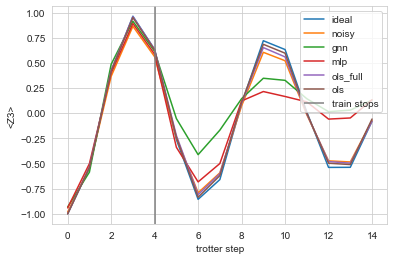

In [100]:
q = 3
plt.plot(exp_Z_all_ideal[:, q], label='ideal')
plt.plot(exp_Z_all_noisy[:, q], label='noisy')
for key, val in exp_Z_all_mitigated_dict.items():
    plt.plot(val[:, q], label=f'{models[key][1]}')
ymin, ymax = plt.gca().get_ylim()
plt.ylim([ymin, ymax])
plt.vlines(x=4, ymin=ymin, ymax=ymax, color='gray', label = 'train stops')
plt.legend(loc='upper right')
plt.ylabel(f'<Z{q}>')
plt.xlabel('trotter step')
plt.show()